<h1><center>Monte Carlo on-policy</center></h1>


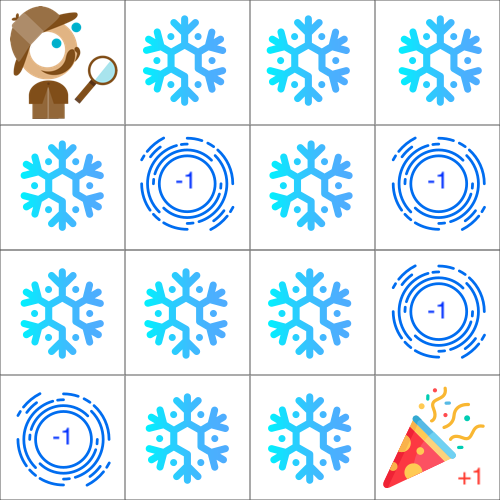

In [93]:
EVIRONMENT_NAME = "FrozenLake-v0"

env = gym.make(EVIRONMENT_NAME)
?env.env

In [94]:
import numpy as np
import gym
import random
import pickle
from collections import defaultdict 

In [95]:
#Thin wrapper around openAI gym
class Environment:
  def __init__(self, environment_name):
    self.env = gym.make(environment_name)
    self.states_number = self.env.observation_space.n
    self.actions_number = self.env.action_space.n

  def generate_episode(self, policy, max_steps):
      state = self.env.reset()
      
      experience = []
      for step in range(max_steps):
          action = policy.act(state, training = True) 
          new_state, reward, done, info = self.env.step(action)
          experience.append((state, action, reward))
          state = new_state
          if done == True:
             break

      return experience 

In [96]:
from itertools import accumulate as _accumulate, repeat as _repeat
from bisect import bisect as _bisect
import random
def choices(population, weights=None, *, cum_weights=None, k=1):
    """Return a k sized list of population elements chosen with replacement.
    If the relative weights or cumulative weights are not specified,
    the selections are made with equal probability.
    """
    n = len(population)
    if cum_weights is None:
        if weights is None:
            _int = int
            n += 0.0    # convert to float for a small speed improvement
            return [population[_int(random.random() * n)] for i in _repeat(None, k)]
        cum_weights = list(_accumulate(weights))
    elif weights is not None:
        raise TypeError('Cannot specify both weights and cumulative weights')
    if len(cum_weights) != n:
        raise ValueError('The number of weights does not match the population')
    bisect = _bisect
    total = cum_weights[-1] + 0.0   # convert to float
    hi = n - 1
    return [population[bisect(cum_weights, random.random() * total, 0, hi)]
            for i in _repeat(None, k)]

In [97]:
#Policy- During training is epsilon greedy and deterministic greedy during recall
class Policy:
  def __init__(self, states_number, actions_number):
     self.Pi = np.full((states_number, actions_number), 1/ actions_number)

  def act(self, state, training = False):
      if training == True:
         #Epsilon greedy: select actions at random with given distribution(weights)   
         actions = [a for a in range(len(self.Pi[state]))]
         action = choices(actions, self.Pi[state, :])[0]
      else:
         #Greedy selecting action with maximal expected returns 
         action = np.argmax(self.Pi[state, :])   
      return action

  def update(self, state, action, value):
      self.Pi[state][action] = value 

In [98]:
class MonteCarloOnPolicy:
     def __init__(self, env= None, policy= None):
         self.policy = policy
         self.env = env
         if env != None:   
            self.Qs = np.zeros((env.states_number, env.actions_number))
         self.MODEL = 'MoteCaloOnPolicyModel'   

     def train(self, max_episodes = 120000, max_steps = 100, discount_rate = 0.98, epsilon = 0.3):
         returns = defaultdict(list)  
         for e in range(max_episodes):
              #Interact with the environemnt and collect experiences: a complete episode  
              episode = env.generate_episode(self.policy, max_steps)
              G = 0
              count =0
              #visit time-steps in reverse order to propely calculate cumulative expected returns
              for i in reversed(range(0, len(episode))):
                  timestep = episode[i]
                  state = timestep[0]
                  action = timestep[1]
                  reward = timestep[2]
                
                  #calculate expected cumulative discounted returns
                  G = discount_rate * G + reward 
      
                  #first visit Monte Carlo 
                  if not (state, action) in [(t[0],t[1]) for t in episode[0:i]]:
                     #add expected return into the state-action history of returns
                     returns[(state, action)].append(G)
                     
                      
                     #Policy evaluation: drive value functiom of state-action pair to mean of all returns
                     self.Qs[state][action] = np.mean(np.array(returns[(state, action)]))
                     
                     #maximal action forcurrent state    
                     max_action = np.argmax(self.Qs[state, : ])

                     for action in range(self.env.actions_number):
                         #Policy improvement
                         if max_action == action:
                            #Increase probability of optimal action (1-epsilon)    
                            self.policy.update(state, action, 1 - epsilon + (epsilon / self.env.actions_number)) 
                         else:
                            #Set the probability non-optimal actions to low probability: epsilon/number of actions
                            self.policy.update(state, action, epsilon / self.env.actions_number)
     
         print(self.Qs)
         self.save_model()

     def act(self, state):
         return self.policy.act(state) 

     def save_model(self):
         with open(self.MODEL, 'wb') as fp:
              pickle.dump(self.policy, fp)           
            
     def load_model(self):
         with open (self.MODEL, 'rb') as fp:
              self.policy = pickle.load(fp)
              

In [54]:
env = Environment(EVIRONMENT_NAME)
policy = Policy(env.states_number, env.actions_number)
agent = MonteCarloOnPolicy(env, policy)
agent.train()


[[0.10178146 0.08132846 0.08908326 0.0809028 ]
 [0.0496019  0.0545257  0.05082448 0.08108064]
 [0.09361691 0.080232   0.08253381 0.07471307]
 [0.04755615 0.05302049 0.03927429 0.06918994]
 [0.12051059 0.07879251 0.08539827 0.06863183]
 [0.         0.         0.         0.        ]
 [0.12465333 0.09395547 0.11741747 0.03140506]
 [0.         0.         0.         0.        ]
 [0.08584039 0.12582528 0.11986233 0.17235562]
 [0.17472198 0.27178359 0.22684986 0.15287984]
 [0.32280762 0.28710589 0.23340475 0.12135355]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.19824072 0.32153792 0.41728129 0.28400758]
 [0.40836081 0.66436859 0.62326565 0.54036596]
 [0.         0.         0.         0.        ]]


In [99]:
wins = 0
done = False
env = gym.make(EVIRONMENT_NAME)
agent = MonteCarloOnPolicy()
agent.load_model()

for episode in range(1000):
  state = env.reset()
  done = False

  for step in range(100):
     action = agent.act(state)
     new_state, reward, done, info = env.step(action) 

     if done == True:
        if reward == 1:
           wins +=1
        break
     state = new_state
        
print("wins ratio ", wins/1000) 


wins ratio  0.719


In [100]:
import gym
from IPython import display
import matplotlib.pyplot as plt
import time

wins = 0
done = False
env = gym.make(EVIRONMENT_NAME)
agent = MonteCarloOnPolicy()
agent.load_model()

EPISODES = 2

for episode in range(EPISODES):
  state = env.reset()
  done = False

  for step in range(100):
     env.render()
     display.clear_output(wait=True)
     action = agent.act(state)
     new_state, reward, done, info = env.step(action) 

     if done == True:
        if reward == 1:
           print("episode %d: won"%episode) 
           wins +=1
        else:
           print("episode %d: loss"%episode) 
        env.render()
        display.clear_output(wait=True)
        time.sleep(2)
        break
        time.sleep(1)            
        
     state = new_state
     time.sleep(0.1)  
        
print("wins ratio: ", wins/EPISODES) 

wins ratio:  0.5
